In [6]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#import pandas_profiling as pp

# Preprocessing and pipeline utilities
import sklearn
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB

# Model Evaluation and Selection
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, auc)


In [2]:
df = pd.read_csv('../data/train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


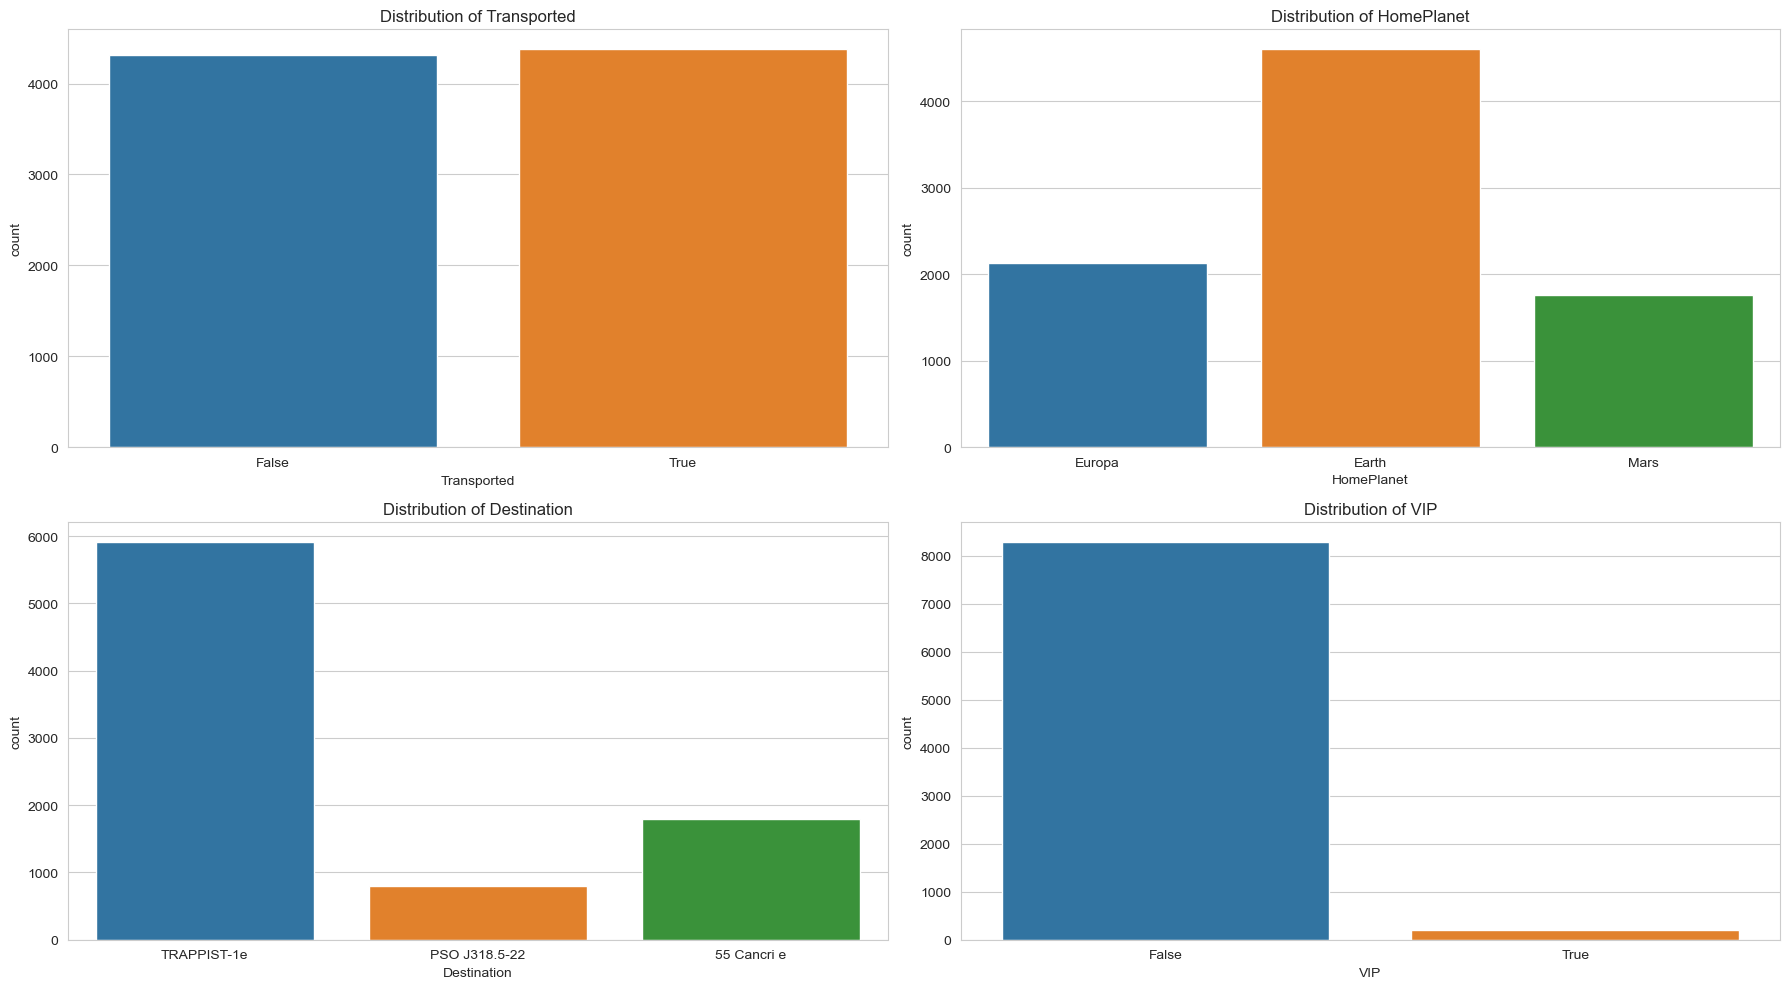

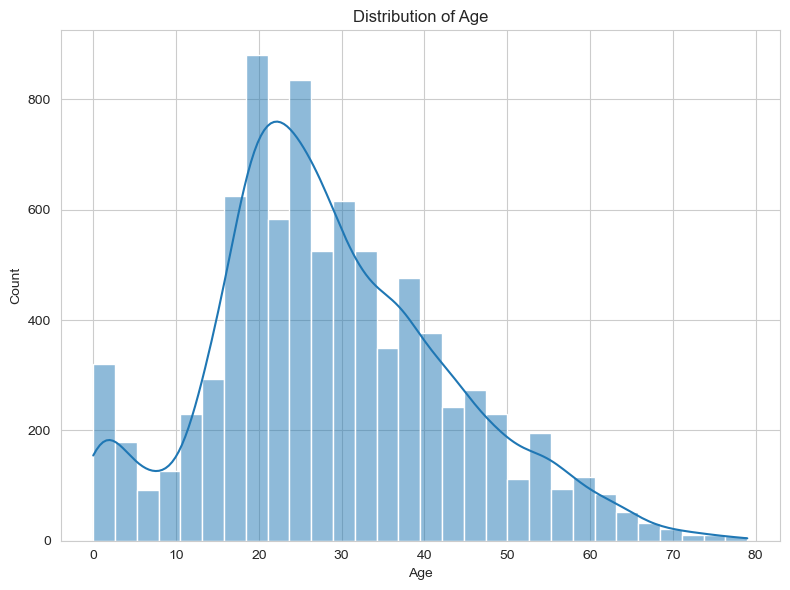

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [14]:
# Set up the aesthetics for the plots
sns.set_style("whitegrid")

# Create a figure with 2x2 subplots
fig, ax = plt.subplots(2, 2, figsize=(18, 10))

# Plot 1: Distribution of the target variable "Transported"
sns.countplot(data=df, x="Transported", ax=ax[0, 0])
ax[0, 0].set_title("Distribution of Transported")

# Plot 2: Distribution of the "HomePlanet" feature
sns.countplot(data=df, x="HomePlanet", ax=ax[0, 1])
ax[0, 1].set_title("Distribution of HomePlanet")

# Plot 3: Distribution of the "Destination" feature
sns.countplot(data=df, x="Destination", ax=ax[1, 0])
ax[1, 0].set_title("Distribution of Destination")

# Plot 4: Distribution of the "VIP" feature
sns.countplot(data=df, x="VIP", ax=ax[1, 1])
ax[1, 1].set_title("Distribution of VIP")

plt.tight_layout()
plt.show()

# Create another figure for the distribution of "Age" as it uses a different plot type
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=df, x="Age", bins=30, kde=True, ax=ax)
ax.set_title("Distribution of Age")
plt.tight_layout()
plt.show()

# Check for missing values in the dataset
missing_values = df.isnull().sum()
print(missing_values)

In [27]:
#concat train and test data
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')
df = pd.concat([df_train, df_test], axis=0, ignore_index=True)
df.to_csv('train_concat.csv', index=False)


## Preprocessing function

In [38]:
df = pd.read_csv('../data/train.csv')
def preprocessing(df):

    def calculate_group_size(passenger_id, df):
        # Extract the prefix from the 'PassengerId'
        prefix = passenger_id.split('_')[0]
        
        # Count the occurrences of the same prefix in the entire DataFrame
        group_size = len(df[df['PassengerId'].str.startswith(prefix)])
        
        return group_size

    # Apply the function to create the 'TravelGroupSize' column
    df['TravelGroupSize'] = df.apply(lambda row: calculate_group_size(row['PassengerId'], df), axis=1)

    # Filling missing values for HomePlanet
    df['HomePlanet'] = df['HomePlanet'].fillna('Missing')

    # Filling missing values for CryoSleep
    df['CryoSleep'] = df['CryoSleep'].fillna('Missing')

    # Filling missing values for Cabin
    df['Cabin'] = df['Cabin'].fillna('Missing')
    
    # Cabin split
    mask = df['Cabin'] != "Missing"

    # Split 'Cabin' into 'Deck', 'Num', and 'Side' columns
    split_values = df['Cabin'].str.split('/', expand=True)

    # Assign the split values to 'Deck' and 'Side' for non-"Unknown" rows
    df.loc[mask, 'Deck'] = split_values[0]
    df.loc[mask, 'Num'] = split_values[1]
    df.loc[mask, 'Side'] = split_values[2]

    # Fill missing
    df['Deck'] = df['Deck'].fillna("Missing")
    df['Num'] = df['Num'].fillna("Missing")
    df['Side'] = df['Side'].fillna("Missing")

    # Filling missing values for Destination
    df['Destination'] = df['Destination'].fillna('Missing')

    # Filling missing values for Age
    df['Age'] = df['Age'].fillna(df['Age'].mean())

    # Filling missing values for VIP
    df['VIP'] = df['VIP'].fillna(False)

    # Filling missing values for amenities
    df[['FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']] = df[['FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']].fillna(0)
    
    # Filling missing values with NaN
    cols_with_missing = df.columns[df.isin(['Missing']).any()].tolist()
    for col in cols_with_missing:
        df[col] = df[col].replace('Missing', np.nan)



    # Less important features
    df = df.drop(columns=['Name', 'PassengerId', 'Cabin'])

    return df

# Assuming you have a DataFrame named 'df' that you want to preprocess
#change path if needed for concat file
df = preprocessing(df)
df.to_csv('../data/train_preprocessed.csv', index=False)

In [31]:
df = pd.read_csv('../data/train_preprocessed.csv')
# Separate features and target variable
X = df.drop(columns=["Transported"])
y = df["Transported"]

# Define numeric and categorical features
numeric_features = ['Age', 'TravelGroupSize','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']
categorical_features = ['HomePlanet', 'Deck', 'Side', 'Destination', 'VIP', 'CryoSleep', 'Num']

# Create transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Use ColumnTransformer to apply transformers to the appropriate columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])


# Define a list of classifiers and their respective hyperparameter grids
classifiers = {
     
    #with non concat with moneatary columns
    # Best SVM Model: {'classifier__C': 8, 'classifier__class_weight': 'balanced', 'classifier__gamma': 0.10999999999999999, 'classifier__kernel': 'rbf', 'classifier__probability': True, 'classifier__random_state': 42, 'classifier__shrinking': True}
    # Best SVM Accuracy: 0.80478  
    'SVM': (SVC(), {
         'classifier__C': [7],
         'classifier__kernel': ['poly'],
         'classifier__gamma': [0.04],
         'classifier__probability': [True],
         'classifier__class_weight': ['balanced'],
         'classifier__shrinking': [True],
         'classifier__random_state': [42],
}),

}

# Create a dictionary to store the best models
best_models = {}
classifier_accuracies = {}

# Iterate through the classifiers and perform GridSearchCV
for clf_name, (clf, param_grid) in classifiers.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', clf)])
    
    stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
    

    grid_search = GridSearchCV(pipeline, param_grid, cv=stratified_kfold, n_jobs=-1,scoring='accuracy')
    grid_search.fit(X, y)
    
    best_models[clf_name] = grid_search.best_estimator_
    best_accuracy = grid_search.best_score_
    classifier_accuracies[clf_name] = best_accuracy
    print(f'Best {clf_name} Model: {grid_search.best_params_}')
    print(f'Best {clf_name} Accuracy: {grid_search.best_score_:.5f}')
  


Best SVM Model: {'classifier__C': 7, 'classifier__class_weight': 'balanced', 'classifier__gamma': 0.04, 'classifier__kernel': 'poly', 'classifier__probability': True, 'classifier__random_state': 42, 'classifier__shrinking': True}
Best SVM Accuracy: 0.79524


In [28]:
final_model=best_models['SVM']
final_model.fit(X,y)


X_test = pd.read_csv('../data/test_preprocessed.csv')


# Load the original test data
original_test_data = pd.read_csv('../data/test.csv')


# Extract the "PassengerId" column
passenger_id_df = original_test_data[['PassengerId']]


y_pred = final_model.predict(X_test)


# Create a DataFrame for the predicted "Transported" values
predicted_df = pd.DataFrame({'Transported': y_pred})

# Concatenate the "PassengerId" and predicted "Transported" DataFrames
submission_df = pd.concat([passenger_id_df, predicted_df], axis=1)

# Save the concatenated DataFrame to a CSV file
submission_df.to_csv('../data/submission_svm.csv', index=False)

In [ ]:
df=pd.read_csv('../data/submission.csv')